## Configuração e Bibliotecas

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv
from pathlib import Path

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

In [7]:

load_dotenv('../.env') 
BASE_DIR = Path.cwd().parent

BRONZE_PATH = BASE_DIR / os.getenv("BRONZE_DATA_PATH")
SILVER_PATH = BASE_DIR / os.getenv("SILVER_DATA_PATH")

print(f"Bronze Path: {BRONZE_PATH}")
print(f"Silver Path: {SILVER_PATH}")

Bronze Path: c:\Users\mvcor\projetos\Avaliação itaú\data\bronze
Silver Path: c:\Users\mvcor\projetos\Avaliação itaú\data\silver


## Carregando variáveis de ambiente e arquivos

In [38]:


df_prev = pd.read_parquet(os.path.join(BRONZE_PATH, "previous_application.parquet"))
df_inst = pd.read_parquet(os.path.join(BRONZE_PATH, "installments_payments.parquet"))
df_bureau = pd.read_parquet(os.path.join(BRONZE_PATH, "bureau.parquet"))
df_bureau_balance = pd.read_parquet(os.path.join(BRONZE_PATH, 'bureau_balance.parquet'))
df_installments = pd.read_parquet(os.path.join(BRONZE_PATH, 'installments_payments.parquet'))
df_cc_balance = pd.read_parquet(os.path.join(BRONZE_PATH, 'credit_card_balance.parquet'))
df_pos_cash = pd.read_parquet(os.path.join(BRONZE_PATH, 'pos_cash_balance.parquet'))

In [ ]:
def health_check(df, table_name):
    """Função para diagnosticar a saúde de qualquer tabela"""
    print(f"\n{'='*50}")
    print(f"HEALTH CHECK: {table_name.upper()}")
    print(f"{'='*50}")
    print(f"Formato: {df.shape[0]} linhas | {df.shape[1]} colunas")
    
    # 1. Duplicatas
    dup_rows = df.duplicated().sum()
    print(f"Linhas duplicadas: {dup_rows}")
    
    # 2. Dados Ausentes (Nulos)
    missing = (df.isnull().sum() / len(df)) * 100
    missing_top = missing[missing > 0].sort_values(ascending=False).head(5)
    print("\nTop 5 Colunas com Valores Nulos (%):")
    if missing_top.empty:
        print("Nenhum valor nulo encontrado!")
    else:
        print(missing_top.to_string())
        
    # 3. Constantes
    constantes = [c for c in df.columns if df[c].nunique() <= 1]
    if constantes:
        print(f" Colunas Constantes (Inúteis): {constantes}")

## Explorando Bureau

***bureau***: All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

***bureau_balance***:

Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

In [22]:
# Health check
health_check(df_bureau, "Bureau")
health_check(df_bureau_balance, "Bureau Balance")


HEALTH CHECK: BUREAU
Formato: 1716428 linhas | 17 colunas
Linhas duplicadas: 0

Top 5 Colunas com Valores Nulos (%):
amt_annuity               71.473490
amt_credit_max_overdue    65.513264
days_enddate_fact         36.916958
amt_credit_sum_limit      34.477415
amt_credit_sum_debt       15.011932

HEALTH CHECK: BUREAU BALANCE
Formato: 27299925 linhas | 3 colunas
Linhas duplicadas: 0

Top 5 Colunas com Valores Nulos (%):
Nenhum valor nulo encontrado!



--- Análise de Datas (DAYS_CREDIT) ---
count    1.716428e+06
mean    -1.142108e+03
std      7.951649e+02
min     -2.922000e+03
25%     -1.666000e+03
50%     -9.870000e+02
75%     -4.740000e+02
max      0.000000e+00
Name: days_credit, dtype: float64


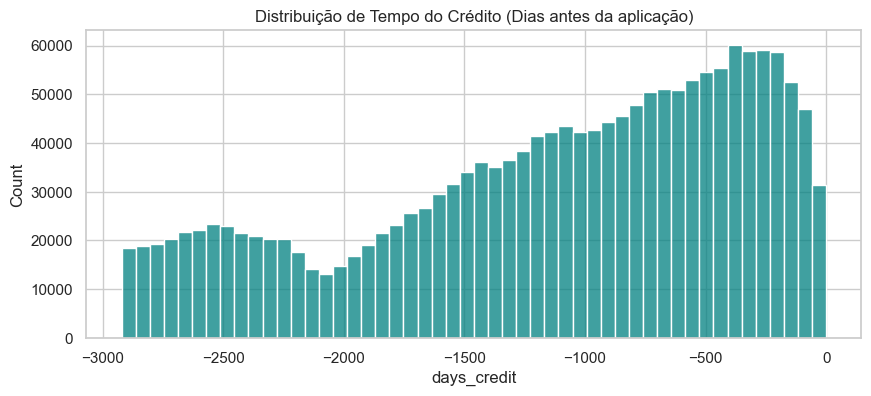

In [13]:
# 2. Consistência de Datas (DAYS_CREDIT)

print(df_bureau['days_credit'].describe())

plt.figure(figsize=(10,4))
sns.histplot(df_bureau['days_credit'], bins=50, color='teal')
plt.title("Distribuição de Tempo do Crédito (Dias antes da aplicação)")
plt.show()

In [23]:
# 3. Estatísticas de Valores Monetários 

display(df_bureau[['amt_credit_sum', 'amt_credit_sum_debt', 'amt_credit_sum_overdue']].describe().T)

,count,mean,std,min,25%,50%,75%,max
amt_credit_sum,1716415.0,354994.591918,1.149811e+06,0.00,51300.0,125518.5,315000.0,585000000.0
amt_credit_sum_debt,1458759.0,137085.119952,6.774011e+05,-4705600.32,0.0,0.0,40153.5,170100000.0
amt_credit_sum_overdue,1716428.0,37.912758,5.937650e+03,0.00,0.0,0.0,0.0,3756681.0


count    1.716415e+06
mean     3.549946e+05
std      1.149811e+06
min      0.000000e+00
25%      5.130000e+04
50%      1.255185e+05
75%      3.150000e+05
max      5.850000e+08
Name: amt_credit_sum, dtype: float64


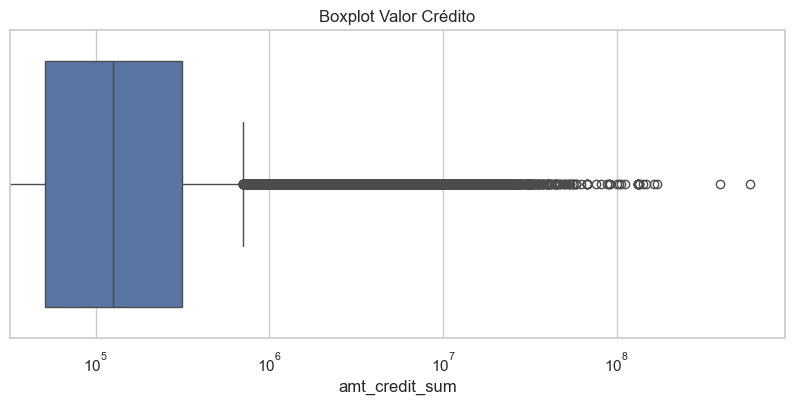

In [14]:
# 3. Outliers em Valores (AMT_CREDIT_SUM)
print(df_bureau['amt_credit_sum'].describe())


plt.figure(figsize=(10,4))
sns.boxplot(x=df_bureau['amt_credit_sum'])
plt.title("Boxplot Valor Crédito")
plt.xscale('log')
plt.show()

## Explorando previous_application

In [24]:
# Health check

health_check(df_prev, "Previous Application")


HEALTH CHECK: PREVIOUS APPLICATION
Formato: 1670214 linhas | 37 colunas
Linhas duplicadas: 0

Top 5 Colunas com Valores Nulos (%):
rate_interest_privileged    99.643698
rate_interest_primary       99.643698
amt_down_payment            53.636480
rate_down_payment           53.636480
name_type_suite             49.119754


In [29]:
# Verificação de colunas de data
date_cols = [c for c in df_prev.columns if 'days' in c]

for col in date_cols:

    print(f'Estatísticas da coluna: {col}')
    print(df_prev[col].describe())
    print('-' * 50)




Estatísticas da coluna: days_decision
count    1.670214e+06
mean    -8.806797e+02
std      7.790997e+02
min     -2.922000e+03
25%     -1.300000e+03
50%     -5.810000e+02
75%     -2.800000e+02
max     -1.000000e+00
Name: days_decision, dtype: float64
--------------------------------------------------
Estatísticas da coluna: days_first_drawing
count    997149.000000
mean     342209.855039
std       88916.115833
min       -2922.000000
25%      365243.000000
50%      365243.000000
75%      365243.000000
max      365243.000000
Name: days_first_drawing, dtype: float64
--------------------------------------------------
Estatísticas da coluna: days_first_due
count    997149.000000
mean      13826.269337
std       72444.869708
min       -2892.000000
25%       -1628.000000
50%        -831.000000
75%        -411.000000
max      365243.000000
Name: days_first_due, dtype: float64
--------------------------------------------------
Estatísticas da coluna: days_last_due_1st_version
count    997149.000

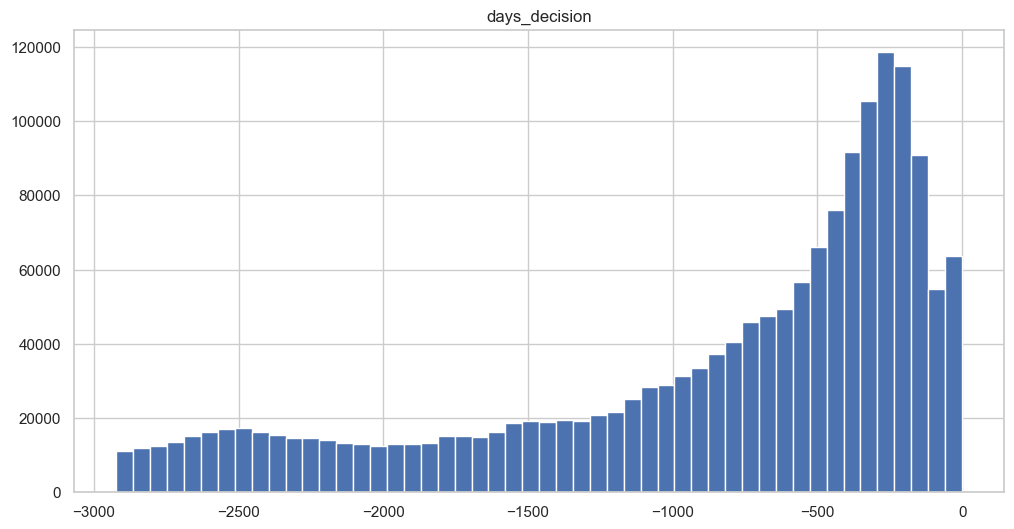

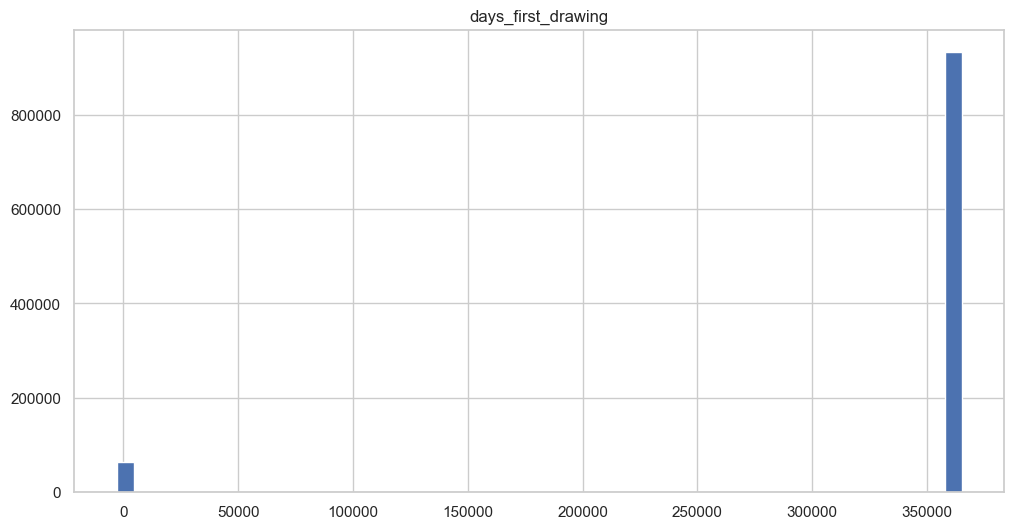

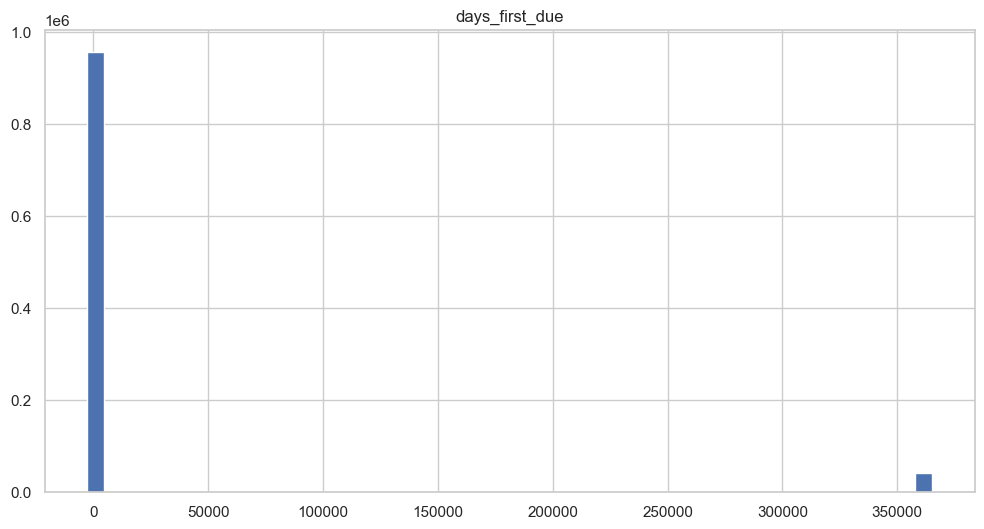

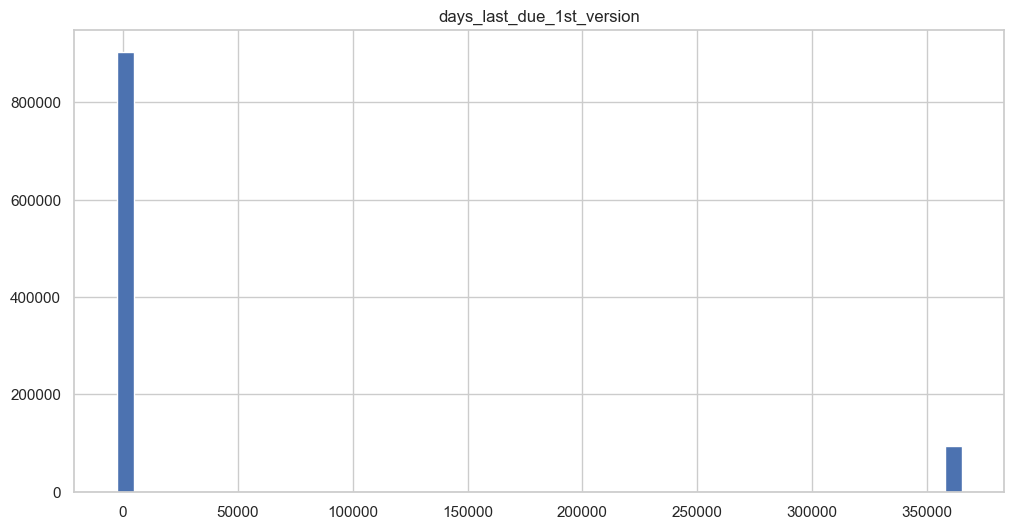

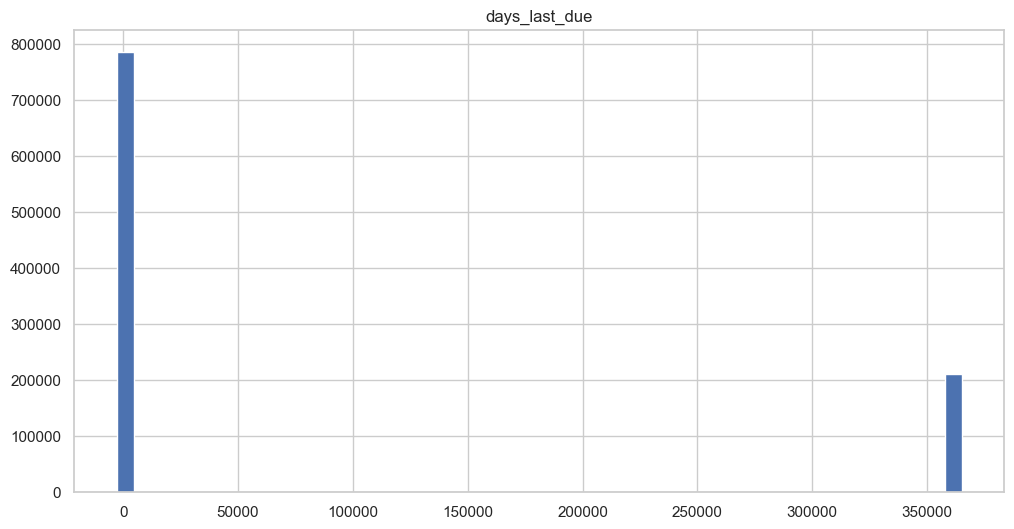

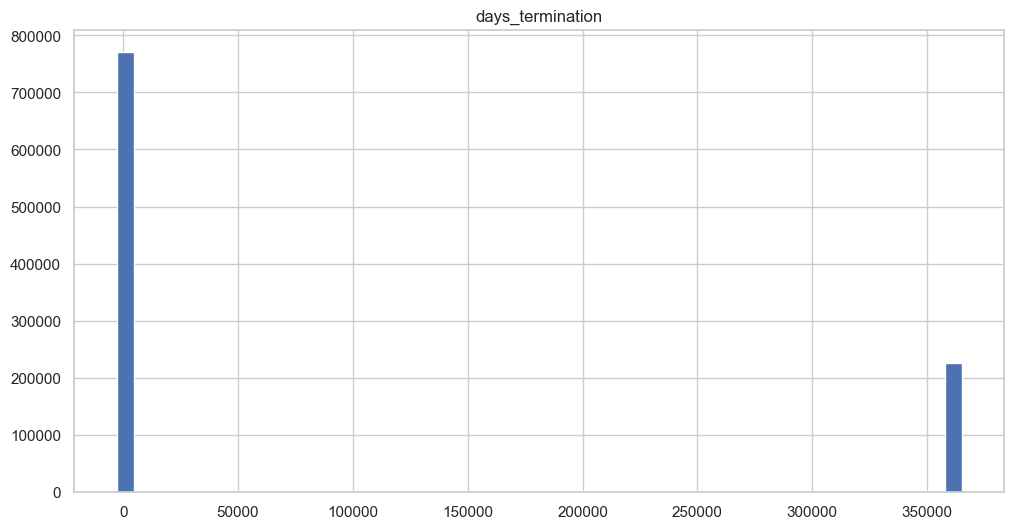

In [30]:
for col in date_cols:
    plt.figure()
    df_prev[col].hist(bins=50)
    plt.title(col)
    plt.show()


In [28]:
for col in date_cols:
    anomalias = (df_prev[col] == 365243).sum()
    if anomalias > 0:
        print(f"{col}: {anomalias} registros ({anomalias/len(df_prev):.1%})")



days_first_drawing: 934444 registros (55.9%)
days_first_due: 40645 registros (2.4%)
days_last_due_1st_version: 93864 registros (5.6%)
days_last_due: 211221 registros (12.6%)
days_termination: 225913 registros (13.5%)


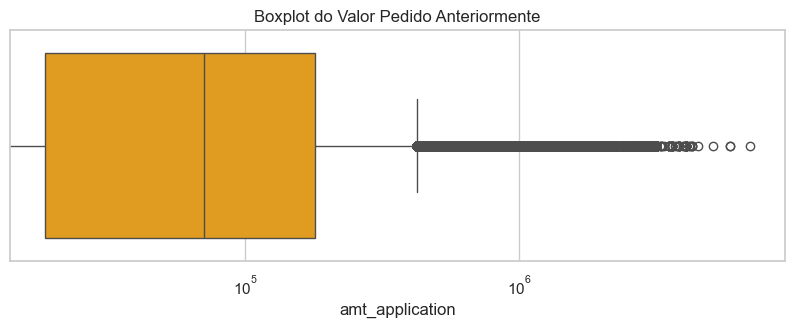

In [31]:
# Visualização de Outlier em $
plt.figure(figsize=(10, 3))
sns.boxplot(x=df_prev['amt_application'], color='orange')
plt.title("Boxplot do Valor Pedido Anteriormente")
plt.xscale('log')
plt.show()

## Explorando installments_payments

In [33]:
#health check
health_check(df_installments, "Installments Payments")


HEALTH CHECK: INSTALLMENTS PAYMENTS
Formato: 13605401 linhas | 8 colunas
Linhas duplicadas: 0

Top 5 Colunas com Valores Nulos (%):
days_entry_payment    0.021352
amt_payment           0.021352


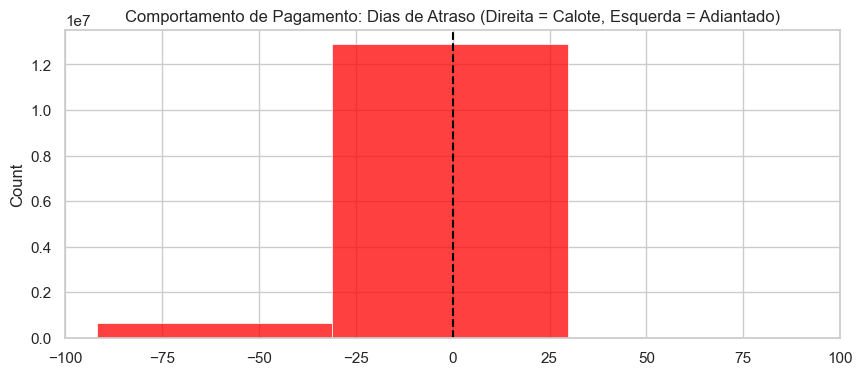

In [35]:
# days_instalment = dia que vencia. days_entry_payment = dia que pagou efetivamente.
#  Dias de Atraso:
atraso = df_installments['days_entry_payment'] - df_installments['days_instalment']

plt.figure(figsize=(10, 4))
sns.histplot(atraso, bins=100, color='red')
plt.title("Comportamento de Pagamento: Dias de Atraso (Direita = Calote, Esquerda = Adiantado)")
plt.xlim(-100, 100) 
plt.axvline(0, color='black', linestyle='--')
plt.show()

In [37]:
# Validação de Pagamento Integral
pagamento_incompleto = (df_installments['amt_payment'] < df_installments['amt_instalment']).sum()
print(f"Parcelas pagas abaixo do valor devido: {pagamento_incompleto} ({pagamento_incompleto/len(df_installments)*100:.1f}%)")

Parcelas pagas abaixo do valor devido: 1295493 (9.5%)


## Cartões de Crédito e POS Cash

In [39]:
health_check(df_cc_balance, "Credit Card Balance")
health_check(df_pos_cash, "POS Cash Balance")


HEALTH CHECK: CREDIT CARD BALANCE
Formato: 3840312 linhas | 23 colunas
Linhas duplicadas: 0

Top 5 Colunas com Valores Nulos (%):
amt_payment_current           19.998063
amt_drawings_atm_current      19.524872
amt_drawings_other_current    19.524872
amt_drawings_pos_current      19.524872
cnt_drawings_atm_current      19.524872

HEALTH CHECK: POS CASH BALANCE
Formato: 10001358 linhas | 8 colunas
Linhas duplicadas: 0

Top 5 Colunas com Valores Nulos (%):
cnt_instalment_future    0.260835
cnt_instalment           0.260675


In [41]:
# Analisando o Saque no Cartão de Crédito
if 'amt_drawings_atm_current' in df_cc_balance.columns:
    saques_atm = df_cc_balance[df_cc_balance['amt_drawings_atm_current'] > 0]
    print(f"\nFaturas com saques em dinheiro (ATM): {len(saques_atm)} ({(len(saques_atm)/len(df_cc_balance))*100:.1f}%)")
    



Faturas com saques em dinheiro (ATM): 424777 (11.1%)


In [42]:
# Status do POS CASH
print("\nStatus dos contratos POS CASH:")
print(df_pos_cash['name_contract_status'].value_counts(normalize=True) * 100)


Status dos contratos POS CASH:
name_contract_status
Active                   91.498764
Completed                 7.447819
Signed                    0.872482
Demand                    0.070640
Returned to the store     0.054603
Approved                  0.049163
Amortized debt            0.006359
Canceled                  0.000150
XNA                       0.000020
Name: proportion, dtype: float64
